In [4]:
from keras.datasets import mnist, cifar100
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

In [5]:
from keras import backend
backend.image_data_format()

'channels_last'

In [6]:
import matplotlib.pyplot as plt

In [7]:
import sys

In [8]:
import numpy as np

In [29]:
class GAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100 # Noiseの次元を決めている。
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.trainable = True       
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)
        
        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
              
        # functional APIの使い方
        # validity = self.discriminator(img) <- img = self.generator(z) <- z
        # cf. https://qiita.com/Mco7777/items/1339d01bc6ef028e7b44
        # my_dense = Dense(5)
        # model_input = Input(shape=(5,))
        # mid = my_dense(model_input)
        # mid2 = my_dense(mid)
        # output = Activation('softmax')(mid2)
        # model = Model(inputs=model_input, outputs=output)
        # つまり、ここのModelはbuild_generator、build_discriminatorのModelとは別。
        # function APIを使わない方法は以下を参照。
        # https://qiita.com/triwave33/items/1890ccc71fab6cbca87e

        # For the combined model we will only train the generator
        # <plan_A>
        self.discriminator.trainable = False
        # <plan_B layer.nameは都度変わるので名前での指定はできなかった。>
        # count = 0
        # for layer in self.combined.layers:
        #     if count == 2:
        #         layer.trainable = False
        #     count += 1
        
        # Model#compile() は、呼び出されると内包しているLayer全てからtrainable_weights
        # を回収する動きをするため、compile()前のtrainableの指定が有効とのことから、
        # plan_Aで、combined modelだけtrainable=Falseにできると考えられる。
        # https://qiita.com/mokemokechicken/items/937a82cfdc31e9a6ca12
        # しかし、discriminatorのsummary()のパラメーターが2倍になってしまう。
        # Plan_AでもPlan_Bも同様。
        # 12-14行目を62行目以降に持って方法では、combinedのNon-trainがおかしくなる。
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
    def build_generator(self):
        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh')) # activation='tanh'なので-1,1の範囲の値を持つ。
        model.add(Reshape(self.img_shape))
        # model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
    
    def build_discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)
    
    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        # (X_train, _), (_, _) = mnist.load_data()
        (X_train, y_train), (_, _) = cifar100.load_data(label_mode='fine')
        
        # Load CIFAR10 data
        # (x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

        # Select frog images (class 6)
        X_train = X_train[y_train.flatten() == 7]

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        # X_train = np.expand_dims(X_train, axis=3) # Insert a new axis.

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid) # 単一バッチデータにつき一度の勾配更新を行う。
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            # train_on_batchは学習の損失を表すスカラ値（モデルが単一の出力を持ち，かつ評価関数がない場合），
            # モデルが複数の出力や評価関数metrics=['accuracy']を持つ場合はスカラ値のリストを戻り値として返す。
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # The arrays to be added. If x1.shape != x2.shape,>-broadcast

            # ---------------------
            #  Train Generator
            # ---------------------
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G acc.: %.2f%%]" % (epoch, d_loss[0], 100*d_loss[1], 100*g_loss[1]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                
    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()

In [30]:
gan = GAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 512)               1573376   
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 257       
Total params: 1,704,961
Trainable params: 1,704,961
Non-trainable params: 0
_________________________________________________________________


In [31]:
gan.generator.summary()
gan.discriminator.summary()
gan.combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 100)               0         
_________________________________________________________________
sequential_12 (Sequential)   (None, 32, 32, 3)         3838720   
Total params: 3,838,720
Trainable params: 3,835,136
Non-trainable params: 3,584
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_11 (Sequential)   (None, 1)                 1704961   
Total params: 3,409,922
Trainable params: 1,704,961
Non-trainable params: 1,704,961
_________________________________________________________________
____________________________________________

In [32]:
gan.train(epochs=30000, batch_size=32, sample_interval=200)

0 [D loss: 0.633683, acc.: 56.25%] [G acc.: 75.00%]
1 [D loss: 0.620566, acc.: 57.81%] [G acc.: 81.25%]
2 [D loss: 0.432957, acc.: 78.12%] [G acc.: 56.25%]
3 [D loss: 0.415491, acc.: 70.31%] [G acc.: 56.25%]
4 [D loss: 0.398017, acc.: 70.31%] [G acc.: 40.62%]
5 [D loss: 0.340805, acc.: 85.94%] [G acc.: 40.62%]
6 [D loss: 0.292392, acc.: 93.75%] [G acc.: 28.12%]
7 [D loss: 0.414597, acc.: 78.12%] [G acc.: 25.00%]
8 [D loss: 0.252314, acc.: 92.19%] [G acc.: 28.12%]
9 [D loss: 0.322328, acc.: 92.19%] [G acc.: 25.00%]
10 [D loss: 0.380730, acc.: 89.06%] [G acc.: 9.38%]
11 [D loss: 0.272444, acc.: 89.06%] [G acc.: 9.38%]
12 [D loss: 0.291389, acc.: 89.06%] [G acc.: 3.12%]
13 [D loss: 0.248001, acc.: 93.75%] [G acc.: 3.12%]
14 [D loss: 0.255772, acc.: 92.19%] [G acc.: 0.00%]
15 [D loss: 0.335062, acc.: 90.62%] [G acc.: 6.25%]
16 [D loss: 0.212261, acc.: 95.31%] [G acc.: 3.12%]
17 [D loss: 0.339753, acc.: 93.75%] [G acc.: 0.00%]
18 [D loss: 0.387016, acc.: 90.62%] [G acc.: 3.12%]
19 [D loss: 

In [33]:
gan.generator.save('./saved_model/gan_cifar_generator.h5')
gan.discriminator.save('./saved_model/gan_cifar_discriminator.h5')

In [43]:
from keras.models import load_model
gan.generator = load_model('./saved_model/gan_generator.h5')
gan.discriminator = load_model('./saved_model/gan_discriminator.h5')

In [63]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, 100)) # 平均0、標準偏差1の正規分布, shape = (r * c, 100)
noise.shape #generatorに(100,1)を入れたらエラー

(25, 100)

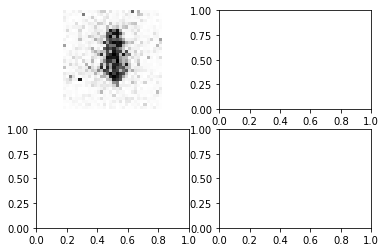

In [64]:
gen_imgs = gan.generator.predict(noise) # -1,1の値を持つ。
gen_imgs = (0.5 * gen_imgs + 0.5) * 1 #0,1にrescale
fig, axs = plt.subplots(2, 2)
axs[0,0].axis('off')
axs[0,0] = axs[0,0].imshow(gen_imgs[0, :,:,0], cmap='gray') # shape = (1, 100)だとエラーが出る。

In [57]:
from PIL import Image

In [58]:
r, c = 1, 1
noise = np.random.normal(0, 1, (r * c, 100)) # 平均0、標準偏差1の正規分布, shape = (r * c, 100)
noise.shape #generatorに(100,1)を入れたらエラー
gen_imgs = gan.generator.predict(noise) # -1,1の値を持つ。
gen_imgs = (0.5 * gen_imgs + 0.5) * 255 #0,255にrescale
gen_imgs = gen_imgs[0].astype('uint8')

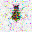

In [59]:
# img_RGB = np.concatenate((gen_imgs, gen_imgs, gen_imgs), axis=2) # 3色にしないとエラーがでる。
img = Image.fromarray(gen_imgs)
img

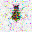

In [60]:
zero_array = np.zeros((32,32,3), dtype='uint8') # Broadcastで28,28,3にしてしまう。
zero_array.dtype
gen_imgs = zero_array + gen_imgs
img = Image.fromarray(gen_imgs)
img

In [50]:
(X_train, _), (_, _) = mnist.load_data()

In [51]:
# Rescale -1 to 1
X_train = X_train / 127.5 - 1.
# X_train = np.expand_dims(X_train, axis=3) # Insert a new axis.
X_train.shape

(60000, 28, 28)

In [88]:
# compile後にFreezeすると、パラーメータが倍表示される。
# https://www.mathgram.xyz/entry/keras/tips/freeze
modelA = Sequential([
    Dense(100, input_dim=10),
    Activation('relu'),
    Dense(10),
    Activation('softmax'),
])

modelB = Sequential([
    Dense(100, input_dim=10),
    Activation('relu'),
    Dense(10),
    Activation('softmax'),
])


In [89]:
# パラメータが2倍になってしまう。
modelA.compile(optimizer="adam", loss="categorical_crossentropy")
modelA.trainable = False
modelA.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_154 (Dense)            (None, 100)               1100      
_________________________________________________________________
activation_105 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_155 (Dense)            (None, 10)                1010      
_________________________________________________________________
activation_106 (Activation)  (None, 10)                0         
Total params: 4,220
Trainable params: 2,110
Non-trainable params: 2,110
_________________________________________________________________


In [90]:
# コンパイルしなくても、Freezeできているように見える。
modelB.trainable = False
modelB.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_156 (Dense)            (None, 100)               1100      
_________________________________________________________________
activation_107 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_157 (Dense)            (None, 10)                1010      
_________________________________________________________________
activation_108 (Activation)  (None, 10)                0         
Total params: 2,110
Trainable params: 0
Non-trainable params: 2,110
_________________________________________________________________


In [93]:
# コンパイルするまえにFreezeすれば、パラメータ数は正常。
modelB.trainable = True
modelB.compile(optimizer="adam", loss="categorical_crossentropy")
modelB.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_156 (Dense)            (None, 100)               1100      
_________________________________________________________________
activation_107 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_157 (Dense)            (None, 10)                1010      
_________________________________________________________________
activation_108 (Activation)  (None, 10)                0         
Total params: 2,110
Trainable params: 2,110
Non-trainable params: 0
_________________________________________________________________


In [94]:
# もう一度コンパイルしてフリーズすれば、パラメータ数は正常。コンパイルしなければ異常。
modelB.trainable = False
modelB.compile(optimizer="adam", loss="categorical_crossentropy")
modelB.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_156 (Dense)            (None, 100)               1100      
_________________________________________________________________
activation_107 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_157 (Dense)            (None, 10)                1010      
_________________________________________________________________
activation_108 (Activation)  (None, 10)                0         
Total params: 2,110
Trainable params: 0
Non-trainable params: 2,110
_________________________________________________________________


In [28]:
(X_train, y_train), (_, _) = cifar100.load_data(label_mode='fine')
X_train = X_train[y_train.flatten() == 7]
X_train.shape

(500, 32, 32, 3)